In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gpu-runtime/BUAN_6341_assignment_1.pdf
/kaggle/input/gpu-runtime/sgemm_product.csv
/kaggle/input/gpu-runtime/ML Assignment 1 Report.pdf
/kaggle/input/gpu-runtime/Attribute Information.txt


In [2]:
#import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import neighbors, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

# Dataset Information

This data set measures the running time of a matrix-matrix product A · B = C, where all matrices have size 2048 x 2048, using a parameterizable SGEMM GPU kernel with 241600 possible parameter combinations. For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. All times are measured in milliseconds.

The experiment was run on a desktop workstation running Ubuntu 16.04 Linux with an Intel Core i5 (3.5GHz), 16GB RAM, and a NVidia Geforce GTX 680 4GB GF580 GTX-1.5GB GPU.

#### Attribute Information:

Independent variables:
- 1-2. MWG, NWG: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)
- 3. KWG: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)
- 4-5. MDIMC, NDIMC: local workgroup size: {8, 16, 32} (integer)
- 6-7. MDIMA, NDIMB: local memory shape: {8, 16, 32} (integer)
- 8. KWI: kernel loop unrolling factor: {2, 8} (integer)
- 9-10. VWM, VWN: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)
- 11-12. STRM, STRN: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)
- 13-14. SA, SB: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)

Output:
- 15-18. Run1, Run2, Run3, Run4: performance times in milliseconds for 4 independent runs using the same parameters. They range between 13.25 and 3397.08.

# Exploratory Data Analysis

Read data from our csv file.

In [3]:
df = pd.read_csv('/kaggle/input/gpu-runtime/sgemm_product.csv')
sns.set()

First of all we will check if there are any nulls in our dataset.

In [4]:
print("Number of nulls for each column:")
print(df.isnull().sum())
print(df.shape)

Number of nulls for each column:
MWG          0
NWG          0
KWG          0
MDIMC        0
NDIMC        0
MDIMA        0
NDIMB        0
KWI          0
VWM          0
VWN          0
STRM         0
STRN         0
SA           0
SB           0
Run1 (ms)    0
Run2 (ms)    0
Run3 (ms)    0
Run4 (ms)    0
dtype: int64
(241600, 18)


We see that we have no nulls, so it will not be necessary to do any null value treatment.

We opt to simplify the target variable in just one column because the four runs are from the same program.

In [5]:
df['Runtime']=df[['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)']].mean(axis=1)
df = df.drop(columns =['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)'], axis = 1)
df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Runtime
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,118.6625


We can also check the type of our features using the function info from pandas.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 15 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   MWG      241600 non-null  int64  
 1   NWG      241600 non-null  int64  
 2   KWG      241600 non-null  int64  
 3   MDIMC    241600 non-null  int64  
 4   NDIMC    241600 non-null  int64  
 5   MDIMA    241600 non-null  int64  
 6   NDIMB    241600 non-null  int64  
 7   KWI      241600 non-null  int64  
 8   VWM      241600 non-null  int64  
 9   VWN      241600 non-null  int64  
 10  STRM     241600 non-null  int64  
 11  STRN     241600 non-null  int64  
 12  SA       241600 non-null  int64  
 13  SB       241600 non-null  int64  
 14  Runtime  241600 non-null  float64
dtypes: float64(1), int64(14)
memory usage: 27.6 MB


We see as checked before that there are no nulls and also every feature is an int, except our target that is float, so it should not be necessary to do any special feature treatment. 

We can also visualize the distribution of each feature.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9303f16d10>,
      dtype=object)

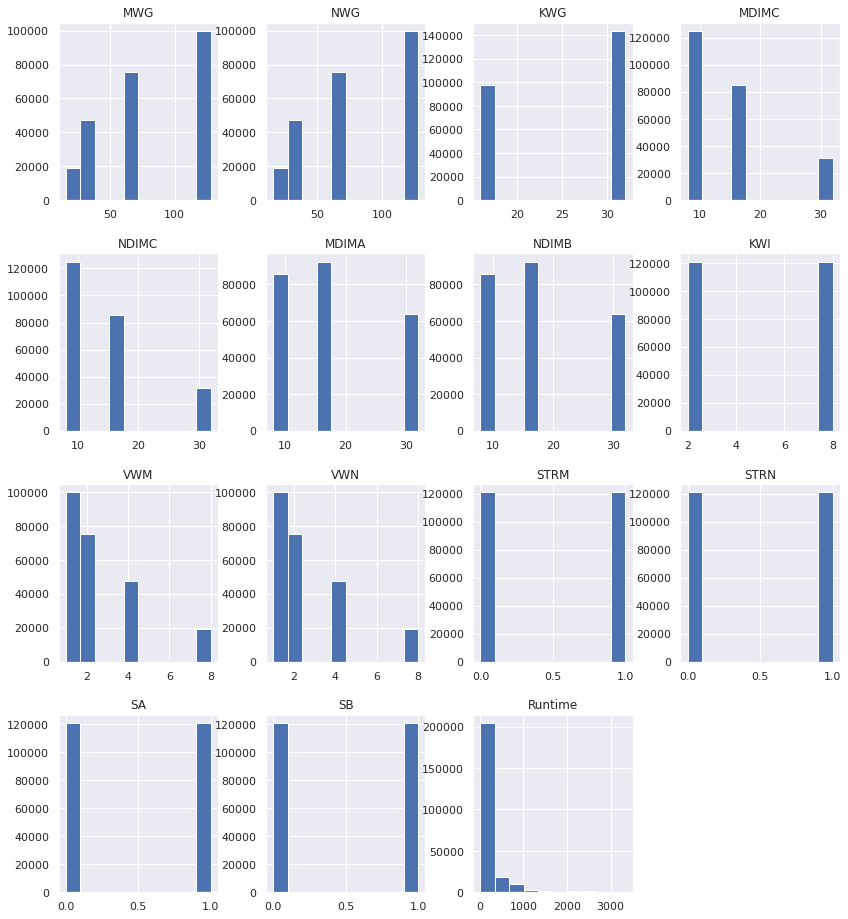

In [7]:
sns.set()
df.hist(figsize=(14,16))

And as expected, we can see that every int variable is categorical while the target is continuous. We also realize that the target variable has some values that are worth studying in case they were outliers.

Additionally, we can see some more basic stats using the function describe from pandas.

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MWG,241600.0,80.415364,42.469220,16.0000,32.0000,64.00,128.0000,128.0000
NWG,241600.0,80.415364,42.469220,16.0000,32.0000,64.00,128.0000,128.0000
KWG,241600.0,25.513113,7.855619,16.0000,16.0000,32.00,32.0000,32.0000
MDIMC,241600.0,13.935894,7.873662,8.0000,8.0000,8.00,16.0000,32.0000
NDIMC,241600.0,13.935894,7.873662,8.0000,8.0000,8.00,16.0000,32.0000
MDIMA,241600.0,17.371126,9.389418,8.0000,8.0000,16.00,32.0000,32.0000
NDIMB,241600.0,17.371126,9.389418,8.0000,8.0000,16.00,32.0000,32.0000
KWI,241600.0,5.000000,3.000006,2.0000,2.0000,5.00,8.0000,8.0000
VWM,241600.0,2.448609,1.953759,1.0000,1.0000,2.00,4.0000,8.0000
VWN,241600.0,2.448609,1.953759,1.0000,1.0000,2.00,4.0000,8.0000


# Preprocessing

### Outliers

We see that although the Runtime mean is 217.57 and the median just 69.79, its maximum value is 3341.51, so it is worth checking if there are any outliers in our data.

Lets check it with a boxplot and remove it if it is necessary.

<img src="https://miro.medium.com/max/8000/1*0MPDTLn8KoLApoFvI0P2vQ.png" width="500" align="left">

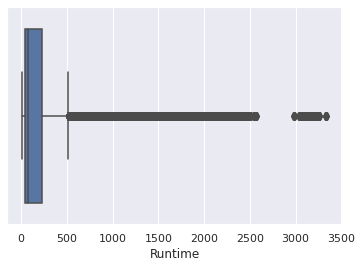

In [9]:
sns.boxplot(x=df['Runtime']);

We opt to not take into account those values that form part of the outliers.

In [10]:
Q1=df['Runtime'].quantile(0.25)
Q3=df['Runtime'].quantile(0.75)
IQR = Q3 - Q1
MIN=Q1-1.5*IQR
MAX=Q3+1.5*IQR
df = df[(df.Runtime>MIN) & (df.Runtime<MAX)]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MWG,214833.0,75.688037,41.968313,16.0000,32.000,64.00,128.0000,128.0000
NWG,214833.0,75.761619,41.997377,16.0000,32.000,64.00,128.0000,128.0000
KWG,214833.0,25.592567,7.839899,16.0000,16.000,32.00,32.0000,32.0000
MDIMC,214833.0,14.475690,8.111065,8.0000,8.000,16.00,16.0000,32.0000
NDIMC,214833.0,14.470700,8.111264,8.0000,8.000,16.00,16.0000,32.0000
MDIMA,214833.0,17.390550,9.375134,8.0000,8.000,16.00,32.0000,32.0000
NDIMB,214833.0,17.388762,9.374445,8.0000,8.000,16.00,32.0000,32.0000
KWI,214833.0,5.005544,3.000002,2.0000,2.000,8.00,8.0000,8.0000
VWM,214833.0,2.339538,1.858623,1.0000,1.000,2.00,4.0000,8.0000
VWN,214833.0,2.345156,1.862122,1.0000,1.000,2.00,4.0000,8.0000


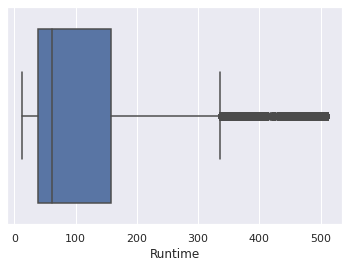

In [11]:
sns.boxplot(x=df['Runtime']);

Now, without the outliers, we can check the distribution of our target.

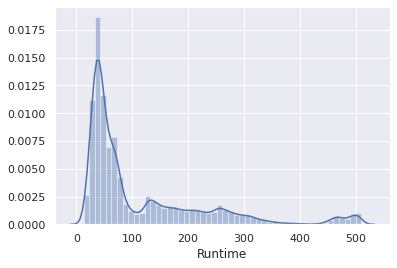

In [12]:
sns.distplot(df['Runtime'])

### Target transformation

As we see in the Runtime histogram we have a logarithmic distribution, so it is a good idea to opt for a logarithmic transformation.

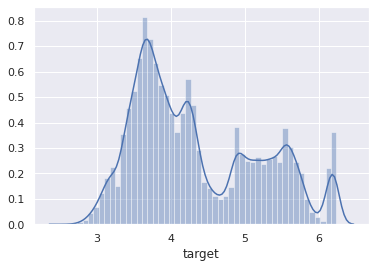

In [13]:
df['target']=np.log(df.Runtime)
sns.distplot(df['target'])

This way we achieve a normal distribution of our target variable.

As a result, now we can visualize a heatmap that will show us the correlation between our features and our target variable.

Text(0.5, 1.0, 'Variable Correlation')

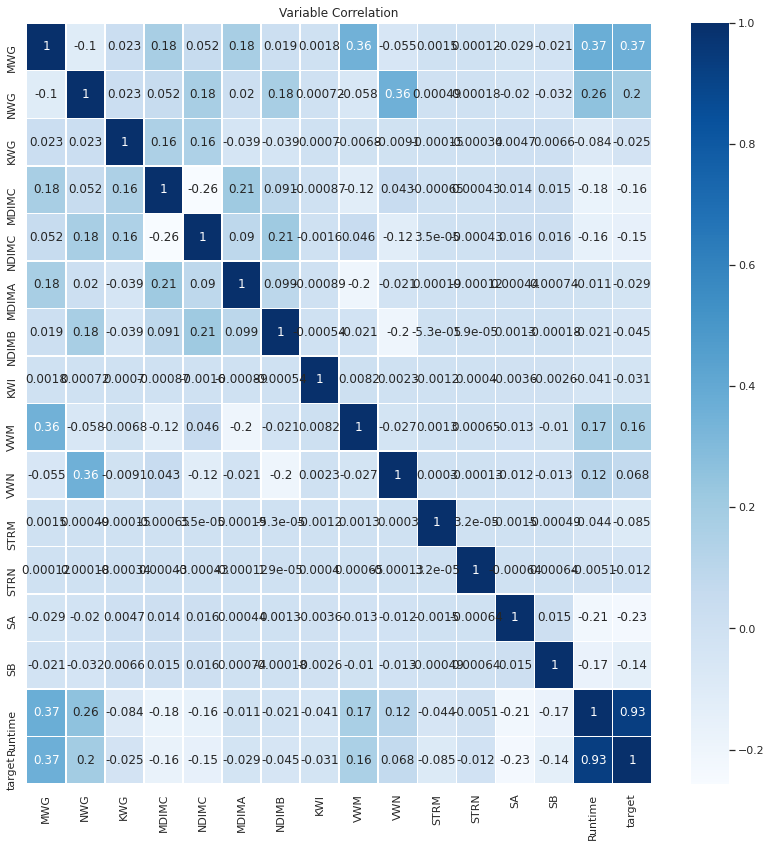

In [14]:
plt.figure(figsize=(14,14))
ax = sns.heatmap(df.corr(),annot=True, linewidths=.5, cmap=plt.cm.Blues)
plt.title('Variable Correlation')

We can also visualize the correlation with our target variable in a sorted and clearer way.

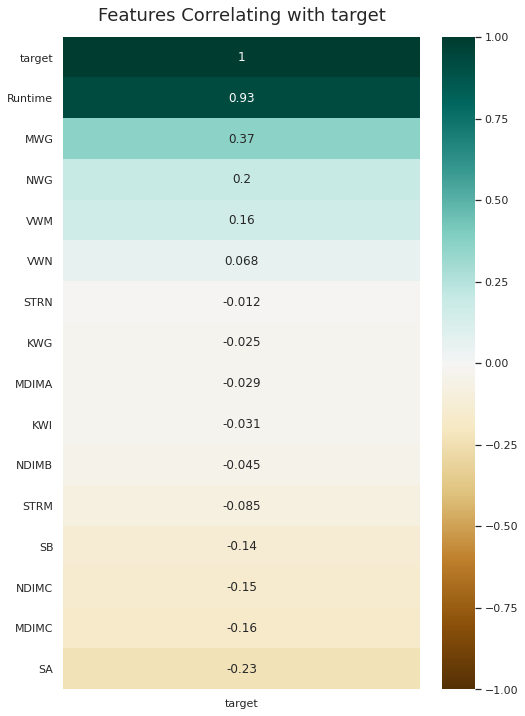

In [15]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['target']].sort_values(by='target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with target', fontdict={'fontsize':18}, pad=16);

### Normalitzation

So as to normalize our data and bring all the variables to the same range we should use an scaler. Due to not having outliers we might have no problem to use MinMaxScaler from sklearn. MinMaxScaler rescales the data set such that all feature values are in the range [0,1].

First of all we have to split our data into features (X) and target (Y).

In [16]:
df_target = df[['target']]
Y = df_target.to_numpy().ravel()
df_features = df.drop(columns=['target','Runtime'])
X = df_features.to_numpy()

In [17]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 1.]]


# Regression

We will apply a regression model using Stochastic Gradient Descent from sklearn.

### Learning rate

First of all we are going to study the affect of the parameter alpha (learning rate). 

MSE with alpha=0.0001: 0.42770654958408827  /  N iterations to converge: 7
MSE with alpha=0.001: 0.42751444700213403  /  N iterations to converge: 7
MSE with alpha=0.01: 0.43109701039831927  /  N iterations to converge: 7
MSE with alpha=0.05: 0.46608521557198096  /  N iterations to converge: 7
MSE with alpha=0.1: 0.5048596177052068  /  N iterations to converge: 7
MSE with alpha=0.2: 0.5557778308047994  /  N iterations to converge: 7
MSE with alpha=0.3: 0.5845276405242286  /  N iterations to converge: 7
MSE with alpha=0.4: 0.6044629390777099  /  N iterations to converge: 7
MSE with alpha=0.5: 0.622450854391986  /  N iterations to converge: 7
MSE with alpha=0.6: 0.6331219605027094  /  N iterations to converge: 7
MSE with alpha=0.7: 0.6442539570142233  /  N iterations to converge: 7


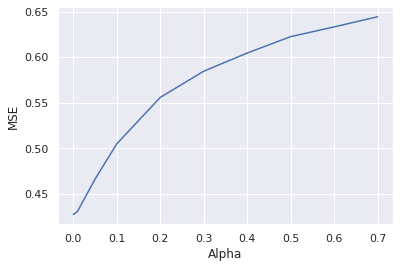

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)
list_alpha = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
list_MSE = []

for i in list_alpha:
    regr = SGDRegressor(alpha = i)
    regr.fit(X_train, Y_train)
    Y_pred = regr.predict(X_test)
    MSE = mean_squared_error(Y_test, Y_pred)
    list_MSE.append(MSE)
    print(f'MSE with alpha={i}: {MSE}  /  N iterations to converge: {regr.n_iter_}')
    
plt.plot(list_alpha,list_MSE)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()

As we can see the lower alpha we get the lower MSE but it usually takes longer to converge.

### Feature selection

So far we have trained our model with every feature we have, now we will try to train it with 8 random features, using 0.0001 as alpha. 

Additionally, the following experiments will be implemented using cross validation, with K-fold=5, so as to prevent possible overfitting and get more reliable results.

In [19]:
for i in range(0,10):
    X = df_features.sample(axis = 1,random_state=i,n=8) 
    print(f'Using features: {X.columns}')
    X = X.to_numpy()
    X = scaler.fit_transform(X)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)

    regr = SGDRegressor(alpha = 0.0001)
    MSE = cross_val_score(regr, X_train, Y_train, cv=5, scoring = "neg_mean_squared_error").mean()
    MSE = abs(MSE)
    print(f'MSE: {MSE}')

Using features: Index(['VWM', 'NDIMB', 'NDIMC', 'STRN', 'KWG', 'SB', 'VWN', 'NWG'], dtype='object')
MSE: 0.6275775239480282
Using features: Index(['MDIMC', 'KWI', 'NDIMB', 'KWG', 'STRM', 'NDIMC', 'NWG', 'SA'], dtype='object')
MSE: 0.5862978674645066
Using features: Index(['STRN', 'NDIMC', 'MDIMA', 'MWG', 'VWN', 'MDIMC', 'NWG', 'STRM'], dtype='object')
MSE: 0.4650673707333726
Using features: Index(['KWI', 'NDIMC', 'NWG', 'KWG', 'SB', 'NDIMB', 'MDIMA', 'MWG'], dtype='object')
MSE: 0.533689600596132
Using features: Index(['NDIMC', 'MDIMC', 'STRN', 'VWN', 'NDIMB', 'SB', 'KWG', 'MWG'], dtype='object')
MSE: 0.5260658105310672
Using features: Index(['MDIMA', 'NWG', 'KWI', 'KWG', 'STRM', 'SB', 'STRN', 'NDIMC'], dtype='object')
MSE: 0.6515878218739897
Using features: Index(['SB', 'SA', 'NDIMB', 'KWI', 'KWG', 'VWM', 'MDIMA', 'STRN'], dtype='object')
MSE: 0.6522065615747656
Using features: Index(['SA', 'STRN', 'KWG', 'MDIMA', 'MWG', 'NWG', 'SB', 'VWM'], dtype='object')
MSE: 0.5345607021488303
Usi

We see that some features set have a higher error than others, so now we are going to study the relevance of each feature training our model from the most correlated feature to the least.

Firstly we will train it with just the most correlated feature, and in each iteration we will add the next most correlated until we have the whole dataset.

In [20]:
best_features = ['MWG', 'SA','NWG',  'VWM','MDIMC', 'NDIMC','SB', 'STRM','NDIMB' ,'VWN', 'KWI','MDIMA','KWG', 'STRN']

Using features: Index(['MWG'], dtype='object')
MSE: 0.6277932523584637
Using features: Index(['MWG', 'SA'], dtype='object')
MSE: 0.5915735386135814
Using features: Index(['MWG', 'SA', 'NWG'], dtype='object')
MSE: 0.5529851403028913
Using features: Index(['MWG', 'SA', 'NWG', 'VWM'], dtype='object')
MSE: 0.5525854563028295
Using features: Index(['MWG', 'SA', 'NWG', 'VWM', 'MDIMC'], dtype='object')
MSE: 0.5100853262470919
Using features: Index(['MWG', 'SA', 'NWG', 'VWM', 'MDIMC', 'NDIMC'], dtype='object')
MSE: 0.4439765671305097
Using features: Index(['MWG', 'SA', 'NWG', 'VWM', 'MDIMC', 'NDIMC', 'SB'], dtype='object')
MSE: 0.43588016569837007
Using features: Index(['MWG', 'SA', 'NWG', 'VWM', 'MDIMC', 'NDIMC', 'SB', 'STRM'], dtype='object')
MSE: 0.43005709415356314
Using features: Index(['MWG', 'SA', 'NWG', 'VWM', 'MDIMC', 'NDIMC', 'SB', 'STRM', 'NDIMB'], dtype='object')
MSE: 0.4304448981346468
Using features: Index(['MWG', 'SA', 'NWG', 'VWM', 'MDIMC', 'NDIMC', 'SB', 'STRM', 'NDIMB',
     

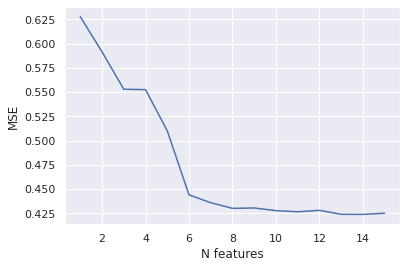

In [21]:
list_MSE = []

for i in range(1,16):
    X = df_features[best_features[:i]]
    print(f'Using features: {X.columns}')
    X = X.to_numpy()
    X = scaler.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)

    regr = SGDRegressor(alpha = 0.0001)
    MSE = cross_val_score(regr, X_train, Y_train, cv=5, scoring = "neg_mean_squared_error").mean()
    MSE = abs(MSE)
    list_MSE.append(MSE)
    print(f'MSE: {MSE}')
    
plt.plot(range(1,16),list_MSE)
plt.xlabel('N features')
plt.ylabel('MSE')
plt.show()

As we can see once we reach the seven most correlated features together we get the lowest error, and the rest of the features do not affect the performance. So now we could opt just to train our model with less features.

Furthermore, to prove that the seven most correlated features are the ones that imply the best performance we can also try the same experiment but beginning with the least correlated.

Using features: Index(['STRN'], dtype='object')
MSE: 0.7234124641894002
Using features: Index(['STRN', 'KWG'], dtype='object')
MSE: 0.7260086696863521
Using features: Index(['STRN', 'KWG', 'MDIMA'], dtype='object')
MSE: 0.7228020867142474
Using features: Index(['STRN', 'KWG', 'MDIMA', 'KWI'], dtype='object')
MSE: 0.7236204385447051
Using features: Index(['STRN', 'KWG', 'MDIMA', 'KWI', 'VWN'], dtype='object')
MSE: 0.7198243173367894
Using features: Index(['STRN', 'KWG', 'MDIMA', 'KWI', 'VWN', 'NDIMB'], dtype='object')
MSE: 0.7188187836515574
Using features: Index(['STRN', 'KWG', 'MDIMA', 'KWI', 'VWN', 'NDIMB', 'STRM'], dtype='object')
MSE: 0.7123553454522775
Using features: Index(['STRN', 'KWG', 'MDIMA', 'KWI', 'VWN', 'NDIMB', 'STRM', 'SB'], dtype='object')
MSE: 0.6987218121004325
Using features: Index(['STRN', 'KWG', 'MDIMA', 'KWI', 'VWN', 'NDIMB', 'STRM', 'SB', 'NDIMC'], dtype='object')
MSE: 0.6862344335540301
Using features: Index(['STRN', 'KWG', 'MDIMA', 'KWI', 'VWN', 'NDIMB', 'STRM

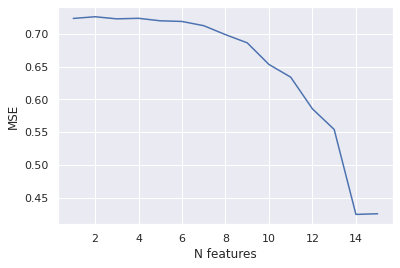

In [22]:
best_features.reverse()
list_MSE = []

for i in range(1,16):
    X = df_features[best_features[:i]]
    print(f'Using features: {X.columns}')
    X = X.to_numpy()
    X = scaler.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)

    regr = SGDRegressor(alpha = 0.0001)
    MSE = cross_val_score(regr, X_train, Y_train, cv=5, scoring = "neg_mean_squared_error").mean()
    MSE = abs(MSE)
    list_MSE.append(MSE)
    print(f'MSE: {MSE}')
    
plt.plot(range(1,16),list_MSE)
plt.xlabel('N features')
plt.ylabel('MSE')
plt.show()

And as proven before we see that it is when we begin to use the most correlated features that the error gets lower.

Unfortunately we do not achieve a lower error than the one with every feature, but with less features to train our model we may reduce our training time.

# Classification

First of all we have to convert this problem into a multi-classification problem, we will assign each value to the quartile it is part of.

In [23]:
X = scaler.fit_transform(df_features)
df_target = pd.qcut(df['target'].values, q=4, labels=False)
Y = df_target.ravel()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33)

We should check if our dataset is balanced so as to know which metrics will be more reliable.

In [24]:
unique, counts = np.unique(Y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 53716, 1: 53703, 2: 53707, 3: 53707}


### Model selection

In the following experiment we will evaluate the following models:
- Decision Tree
- Nearest Neighbor
- Logistic Regression
- Random Forest

#### Decision Tree

Cross validation accuracy with K-fold=5: 0.9580374811108129
Test accuracy: 0.9666125960928134


Text(0.5, 1.0, 'Test Results')

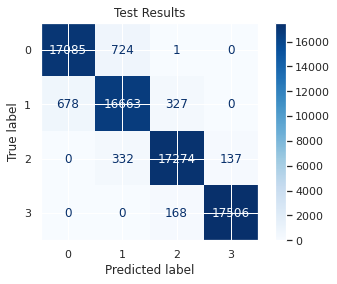

In [25]:
tree_classifier = tree.DecisionTreeClassifier()
tree_score = cross_val_score(tree_classifier, X_train, Y_train, cv = 5, scoring="accuracy")
score = tree_score.mean()
print(f'Cross validation accuracy with K-fold=5: {score}')

tree_classifier.fit(X_train, Y_train)
Y_pred = tree_classifier.predict(X_test)

print(f'Test accuracy: {metrics.accuracy_score(Y_test, Y_pred)}')

disp = metrics.plot_confusion_matrix(tree_classifier, X_test, Y_test, cmap=plt.cm.Blues)
disp.ax_.set_title('Test Results')

#### Nearest Neighbor

Cross validation accuracy with K-fold=5: 0.6747627668416454
Test accuracy: 0.6865082163763312


Text(0.5, 1.0, 'Test Results')

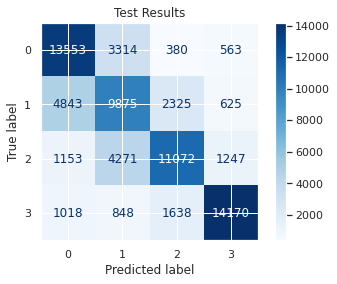

In [26]:
knn_classifier = neighbors.KNeighborsClassifier(n_neighbors=5)
knn_score = cross_val_score(knn_classifier, X_train, Y_train, cv = 5, scoring="accuracy")
score = knn_score.mean()
print(f'Cross validation accuracy with K-fold=5: {score}')

knn_classifier.fit(X_train, Y_train)
Y_pred = knn_classifier.predict(X_test)

print(f'Test accuracy: {metrics.accuracy_score(Y_test, Y_pred)}')

disp = metrics.plot_confusion_matrix(knn_classifier, X_test, Y_test, cmap=plt.cm.Blues)
disp.ax_.set_title('Test Results')

We suppose that Nearest Neighbor performance is worse because of the known "curse of dimensionality", due to the high number of features it is difficult to find the right weights and to determine which features are not important for classification. 

Furthermore, Nearest Neighbor is a distance-based algorithm, so when working with large datasets its performance degrades.

#### Logistic Regression

Cross validation accuracy with K-fold=5: 0.5835220843838146
Test accuracy: 0.5840750405529304


Text(0.5, 1.0, 'Test Results')

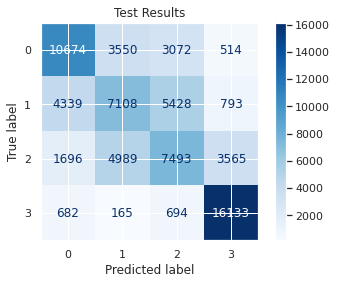

In [27]:
logistic_classifier = LogisticRegression()
logistic_score = cross_val_score(logistic_classifier, X_train, Y_train, cv = 5, scoring="accuracy")
score = logistic_score.mean()
print(f'Cross validation accuracy with K-fold=5: {score}')

logistic_classifier.fit(X_train, Y_train)
Y_pred = logistic_classifier.predict(X_test)

print(f'Test accuracy: {metrics.accuracy_score(Y_test, Y_pred)}')

disp = metrics.plot_confusion_matrix(logistic_classifier, X_test, Y_test, cmap=plt.cm.Blues)
disp.ax_.set_title('Test Results')

We also see that Logistic Regression performance is the worse so far.

Logistic Regression only estimates a linear boundary. So, when there is non-linear separation of labels, Logistic regression could fail badly. As a result we can estimate that our classification is non-linear separable.

#### Random Forest

Cross validation accuracy with K-fold=5: 0.9482832805625643
Test accuracy: 0.9547076662670146


Text(0.5, 1.0, 'Test Results')

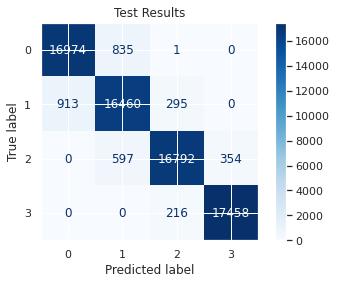

In [28]:
random_classifier = RandomForestClassifier()
random_score = cross_val_score(random_classifier, X_train, Y_train, cv = 5, scoring="accuracy")
score = random_score.mean()
print(f'Cross validation accuracy with K-fold=5: {score}')

random_classifier.fit(X_train, Y_train)
Y_pred = random_classifier.predict(X_test)

print(f'Test accuracy: {metrics.accuracy_score(Y_test, Y_pred)}')

disp = metrics.plot_confusion_matrix(random_classifier, X_test, Y_test, cmap=plt.cm.Blues)
disp.ax_.set_title('Test Results')

Text(0, 0.5, 'Accuracy')

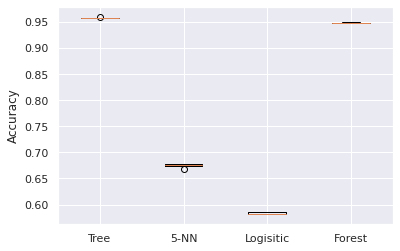

In [29]:
my_dict = {'Tree': tree_score, '5-NN': knn_score, 'Logisitic':logistic_score, 'Forest': random_score}

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.ylabel('Accuracy')

We can conclude that Decision Tree and Random Forest give the best accuracy because every feature is categorical.

Even though Random Forest is an ensemble method from Decision Tree, its performance is not better, so we will opt to perform an hyperparameter search over Random Forest to know if it can get a better accuracy.

### Hyperparameter Search

In [30]:
parameters = {'criterion':['gini', 'entropy'],
              'max_features':[0.1, 0.3, 0.5],
              'n_estimators': range(50, 201, 50)}

In [31]:
rf = RandomForestClassifier()
clf = GridSearchCV(estimator = rf,  param_grid = parameters,scoring = 'accuracy',cv = 5,verbose=0)
grid_search = clf.fit(X_train, Y_train)

# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n'.format(grid_search.best_score_))

# print parameters that give the best results
print('Parameters that give the best results :','\n', (grid_search.best_params_))

# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n', (grid_search.best_estimator_))

GridSearch CV best score : 0.9660

Parameters that give the best results : 
 {'criterion': 'entropy', 'max_features': 0.5, 'n_estimators': 150}


Estimator that was chosen by the search : 
 RandomForestClassifier(criterion='entropy', max_features=0.5, n_estimators=150)
